In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
# Load dataset from directory
dataset_dir = '/content/drive/MyDrive/eye_dataset'
batch_size = 32
img_size = (224, 224)

dataset = tf.keras.utils.image_dataset_from_directory(dataset_dir,
                                       image_size=img_size,
                                       batch_size=batch_size,
                                       label_mode='int')

Found 4217 files belonging to 4 classes.


In [ ]:
def apply_clahe(img):
    """
    Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) to an image.
    """
    img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)  # Convert from RGB to LAB color space
    l, a, b = cv2.split(img_lab)  # Split the LAB image to different channels
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)  # Apply CLAHE to the L-channel
    img_lab = cv2.merge((cl, a, b))  # Merge the CLAHE enhanced L-channel with the a and b channel
    img_clahe = cv2.cvtColor(img_lab, cv2.COLOR_LAB2RGB)  # Convert from LAB to RGB color space
    return img_clahe

In [ ]:
# Load images and labels from directory
def load_images_from_directory(directory):
    images = []
    labels = []
    class_names = sorted(os.listdir(directory))
    for label, class_name in enumerate(class_names):
        class_folder = os.path.join(directory, class_name)
        for filename in os.listdir(class_folder):
            img_path = os.path.join(class_folder, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, img_size)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = apply_clahe(img)
                images.append(img)
                labels.append(label)
    return np.array(images), np.array(labels), class_names

# Load data
images, labels, class_names = load_images_from_directory(dataset_dir)

# Print the class names
print("Class names:", class_names)

# Verify the shapes of images and labels
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)

Class names: ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']
Images shape: (4217, 224, 224, 3)
Labels shape: (4217,)


In [ ]:
# Split data using sklearn train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [ ]:
from keras import layers, applications, models, optimizers, callbacks
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#define data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

def preprocess_and_augment(image, label):
    image = data_augmentation(image)
    image = tf.cast(image, tf.float32)
    image = tf.keras.applications.efficientnet.preprocess_input(image)
    return image, label

def preprocess(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.keras.applications.efficientnet.preprocess_input(image)
    return image, label

# Convert to TensorFlow datasets and apply augmentation to training data
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)) \
    .map(preprocess_and_augment, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
    .batch(batch_size) \
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)) \
    .map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
    .batch(batch_size) \
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)) \
    .map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
    .batch(batch_size) \
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

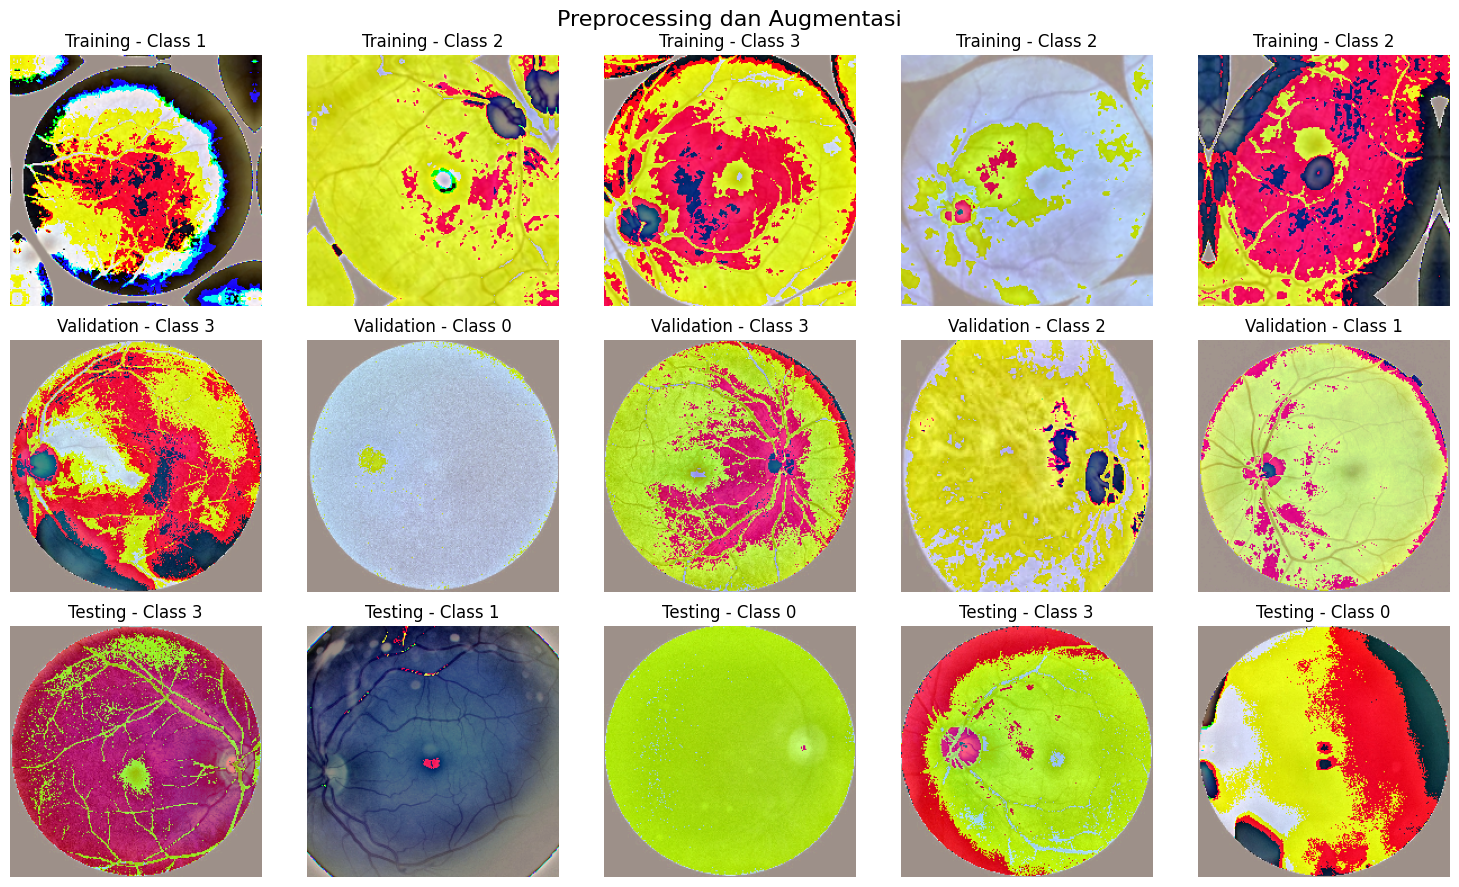

In [ ]:
# Visualize dataset
def visualize_dataset_from_split(train_ds, val_ds, test_ds, num_images=5):
    datasets = {'Training': train_ds, 'Validation': val_ds, 'Testing': test_ds}
    fig, axes = plt.subplots(len(datasets), num_images, figsize=(num_images * 3, len(datasets) * 3))
    fig.suptitle('Preprocessing dan Augmentasi', fontsize=16)

    for ds_idx, (ds_name, ds) in enumerate(datasets.items()):
        for images, labels in ds.take(1):
            for img_idx in range(num_images):
                ax = axes[ds_idx, img_idx]
                ax.imshow(images[img_idx].numpy().astype("uint8"))
                ax.axis('off')
                ax.set_title(f"{ds_name} - Class {labels[img_idx].numpy()}", fontsize=12)

    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()

visualize_dataset_from_split(train_ds, val_ds, test_ds)

In [ ]:
# Load the vgg19 model with pretrained weights
base_model = VGG19(weights='imagenet',
                            include_top=False,
                            input_shape=(img_size[0], img_size[1], 3))

for layer in base_model.layers:
    layer.trainable = False

# Add new layers for fine-tuning
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)  # Assuming 4 classes

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Define the model
model = Model(inputs=base_model.input, outputs=predictions)
# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Set up callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    ModelCheckpoint(filepath='best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
]

In [ ]:
# Train the model on the new data for a few epochs
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=callbacks
)

Epoch 1/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - accuracy: 0.5264 - loss: 2.4553
Epoch 1: val_loss improved from inf to 0.73243, saving model to best_model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 91s 779ms/step - accuracy: 0.5272 - loss: 2.4458 - val_accuracy: 0.6840 - val_loss: 0.7324
Epoch 2/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.7001 - loss: 0.7847
Epoch 2: val_loss improved from 0.73243 to 0.60922, saving model to best_model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 101s 521ms/step - accuracy: 0.7003 - loss: 0.7842 - val_accuracy: 0.7251 - val_loss: 0.6092
Epoch 3/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.7355 - loss: 0.6941
Epoch 3: val_loss did not improve from 0.60922
93/93 ━━━━━━━━━━━━━━━━━━━━ 48s 513ms/step - accuracy: 0.7356 - loss: 0.6938 - val_accuracy: 0.6998 - val_loss: 0.6837
Epoch 4/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.7650 - loss: 0.6185
Epoch 4: val_loss improved from 0.60922 to 0.57603, saving model to best_model.keras
93/

In [ ]:
# Tahap kedua: Unfreeze model dasar untuk fine-tuning, kecuali lapisan BatchNormalization
for layer in base_model.layers:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary(show_trainable=True)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer_2 (InputLayer)          │ (None, 224, 224, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block1_conv1 (Conv2D)               │ (None, 224, 224, 64)         │         1,792 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block1_conv2 (Conv2D)               │ (None, 224, 224, 64)         │        36,928 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block1_pool (MaxPooling2D)          │ (None, 112, 112, 64)         │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block2_conv1 (Conv2D)               │ (None, 112, 112, 128)        │        73,856 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block2_conv2 (Conv2D)               │ (None, 112, 112, 128)        │       147,584 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block2_pool (MaxPooling2D)          │ (None, 56, 56, 128)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block3_conv1 (Conv2D)               │ (None, 56, 56, 256)          │       295,168 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block3_conv2 (Conv2D)               │ (None, 56, 56, 256)          │       590,080 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block3_conv3 (Conv2D)               │ (None, 56, 56, 256)          │       590,080 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block3_conv4 (Conv2D)               │ (None, 56, 56, 256)          │       590,080 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block3_pool (MaxPooling2D)          │ (None, 28, 28, 256)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block4_conv1 (Conv2D)               │ (None, 28, 28, 512)          │     1,180,160 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block4_conv2 (Conv2D)               │ (None, 28, 28, 512)          │     2,359,808 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block4_conv3 (Conv2D)               │ (None, 28, 28, 512)          │     2,359,808 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block4_conv4 (Conv2D)               │ (None, 28, 28, 512)          │     2,359,808 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block4_pool (MaxPooling2D)          │ (None, 14, 14, 512)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block5_conv1 (Conv2D)               │ (None, 14, 14, 512)          │     2,359,808 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block5_conv2 (Conv2D)               │ (None, 14, 14, 512)          │     2,359,808 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block5_conv3 (Conv2D)

 Total params: 21,076,548 (80.40 MB)

 Trainable params: 21,076,548 (80.40 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Fine-tune the model
fine_tune_epochs = 10
total_epochs = 10 + fine_tune_epochs

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    callbacks=callbacks
)

# Load the best model
model.load_weights('best_model.keras')

Epoch 10/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8138 - loss: 0.4869   
Epoch 10: val_loss improved from 0.47796 to 0.47000, saving model to best_model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 155s 1s/step - accuracy: 0.8140 - loss: 0.4864 - val_accuracy: 0.8073 - val_loss: 0.4700
Epoch 11/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 889ms/step - accuracy: 0.8651 - loss: 0.3645
Epoch 11: val_loss improved from 0.47000 to 0.35489, saving model to best_model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 139s 940ms/step - accuracy: 0.8652 - loss: 0.3642 - val_accuracy: 0.8673 - val_loss: 0.3549
Epoch 12/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 892ms/step - accuracy: 0.8994 - loss: 0.2800
Epoch 12: val_loss improved from 0.35489 to 0.33815, saving model to best_model.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 143s 947ms/step - accuracy: 0.8994 - loss: 0.2800 - val_accuracy: 0.8689 - val_loss: 0.3381
Epoch 13/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 887ms/step - accuracy: 0.9095 - loss: 0.2506
Epoch 13: val_loss improved from 0.33815

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 257ms/step
Classification Report:
                       precision    recall  f1-score   support

            cataract       0.92      0.90      0.91       156
diabetic_retinopathy       0.98      1.00      0.99       165
            glaucoma       0.90      0.74      0.81       151
              normal       0.81      0.93      0.86       161

            accuracy                           0.90       633
           macro avg       0.90      0.89      0.89       633
        weighted avg       0.90      0.90      0.90       633

Confusion Matrix:
 [[141   0   9   6]
 [  0 165   0   0]
 [  6   3 112  30]
 [  6   1   4 150]]


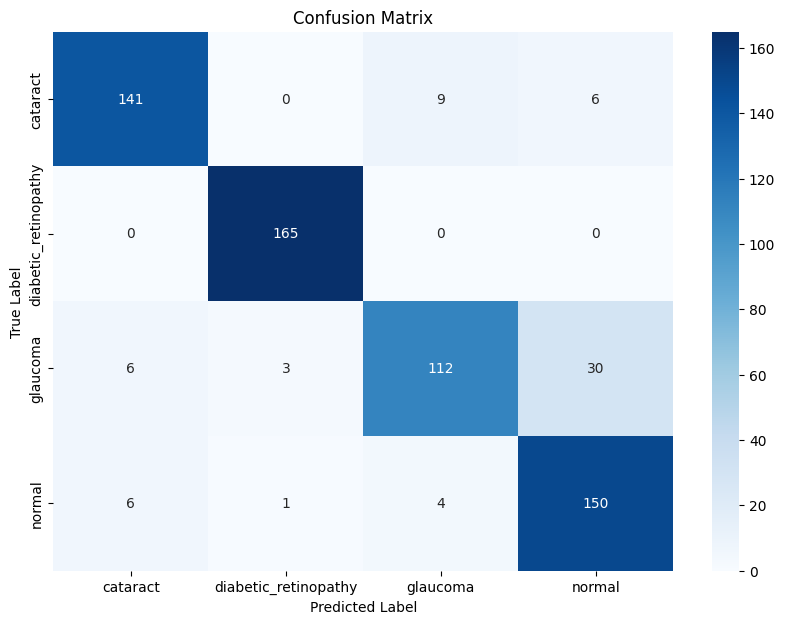

In [ ]:
# Predict labels for the test set
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate classification report
report = classification_report(y_test, y_pred, target_names=class_names)
print("Classification Report:\n", report)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Optional: visualize the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

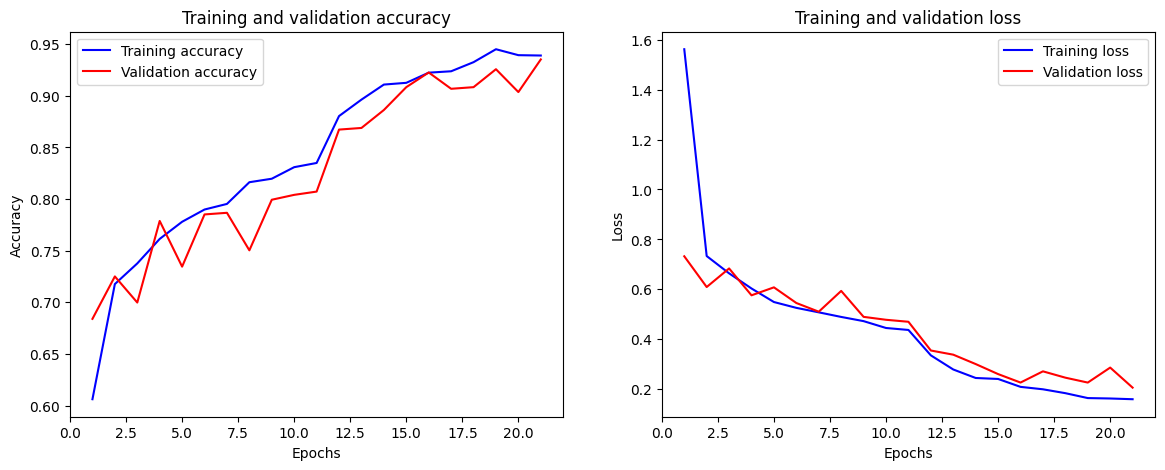

In [ ]:
# Plotting the training history
def plot_training_history(history, fine_tune=False):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    if fine_tune:
        acc += history_fine.history['accuracy']
        val_acc += history_fine.history['val_accuracy']
        loss += history_fine.history['loss']
        val_loss += history_fine.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')  # Menambahkan teks sumbu X
    plt.ylabel('Accuracy')  # Menambahkan teks sumbu Y
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')  # Menambahkan teks sumbu X
    plt.ylabel('Loss')  # Menambahkan teks sumbu Y
    plt.legend()

    plt.show()

# Plotting the training and fine-tuning history
plot_training_history(history, fine_tune=True)

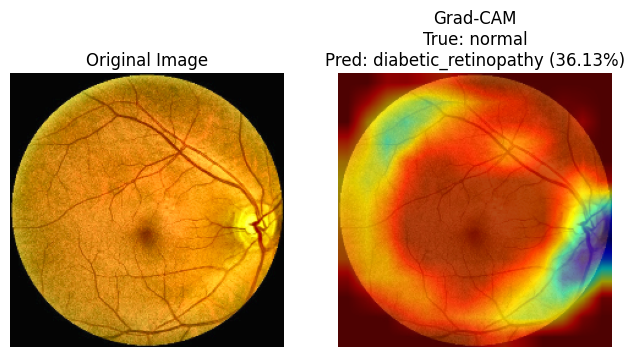

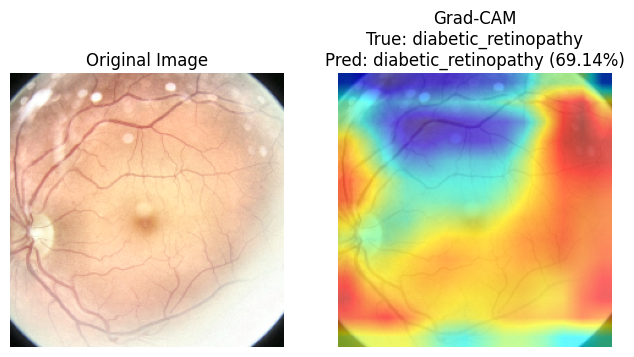

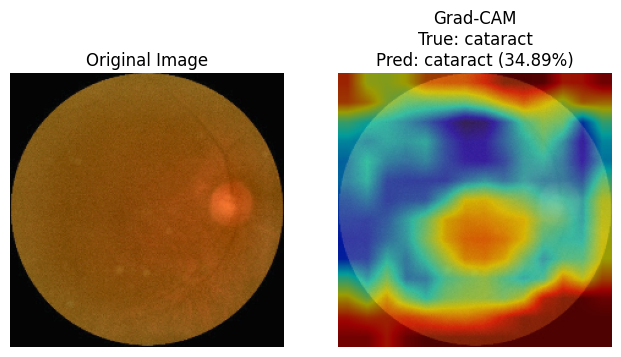

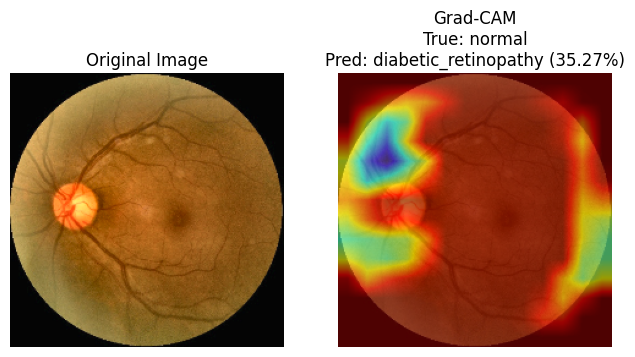

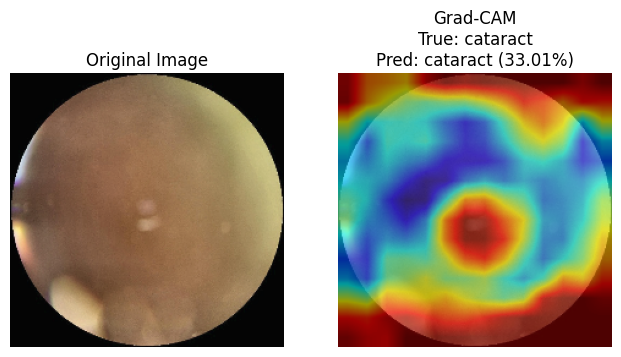

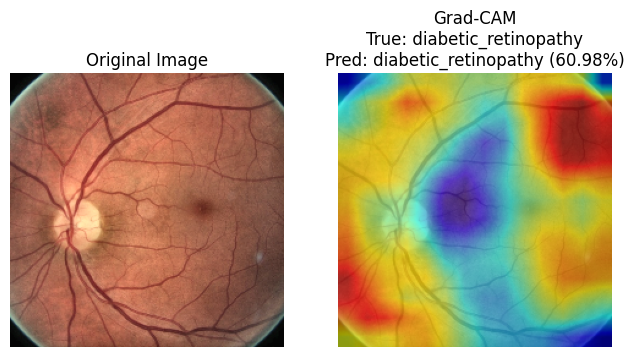

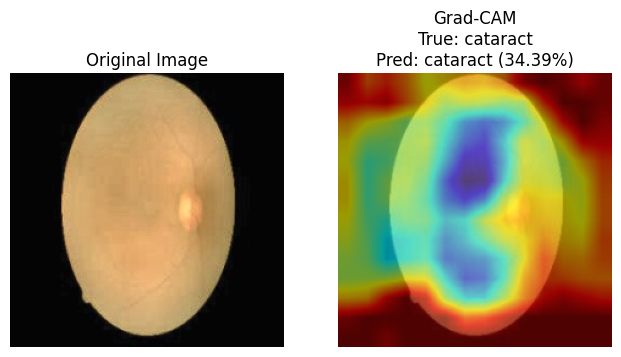

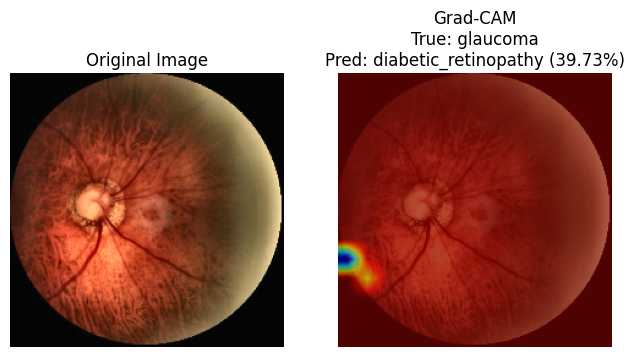

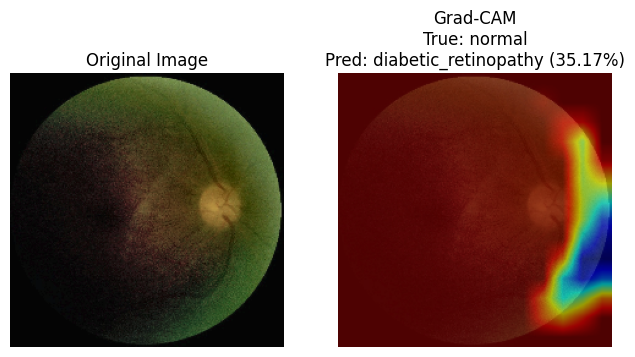

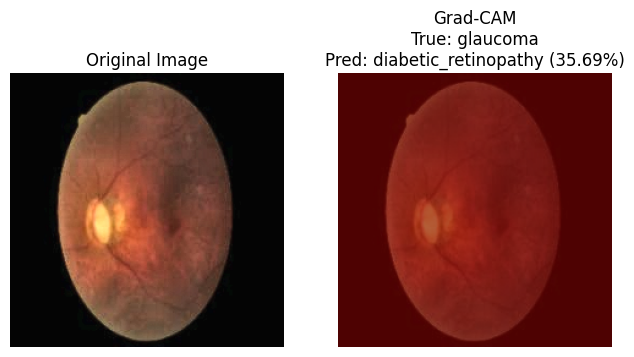

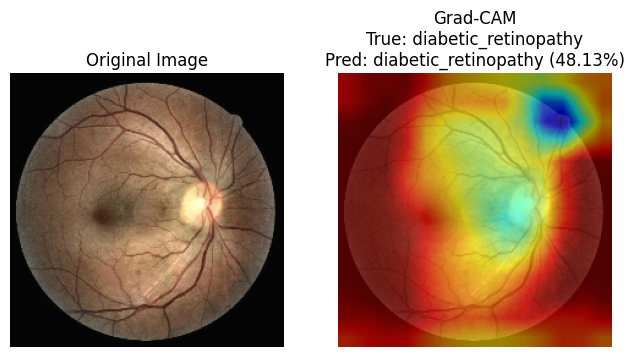

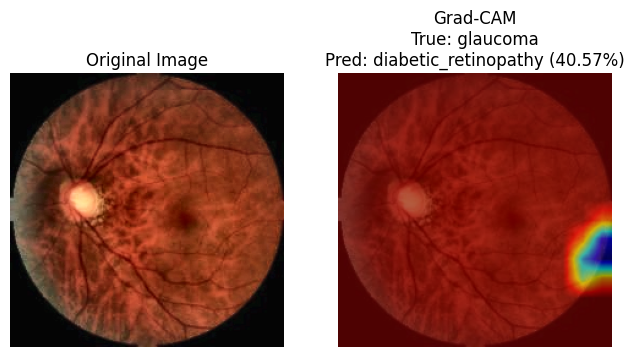

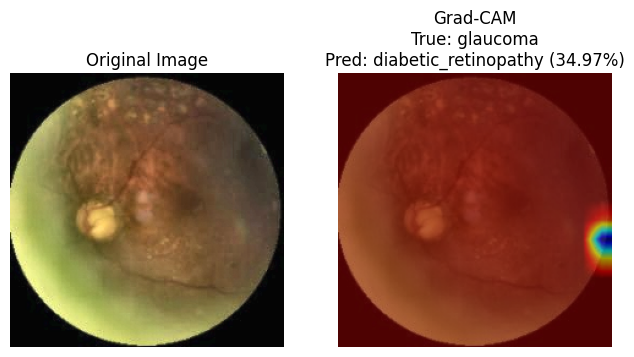

In [ ]:
def get_gradcam_heatmap(model, img_array, class_index, layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

    conv_outputs = conv_outputs[0].numpy()
    pooled_grads = pooled_grads.numpy()

    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap, predictions[0]

def apply_heatmap(image, heatmap, alpha=0.4, colormap=cv2.COLORMAP_JET):
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, colormap)
    overlay = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
    return overlay

# Nama layer konvolusi terakhir dalam model
last_conv_layer_name = "block5_conv4"

# Definisikan label kelas secara manual
class_labels = ["cataract", "diabetic_retinopathy", "glaucoma", "normal"]

# Ambil beberapa gambar dari set tes untuk visualisasi
sample_test_images = X_test[:13]
sample_test_labels = y_test[:13]

# Rescale gambar jika diperlukan
sample_test_images_rescaled = sample_test_images / 255.0

for i in range(len(sample_test_images)):
    img_array = np.expand_dims(sample_test_images_rescaled[i], axis=0)
    true_class_index = sample_test_labels[i]
    heatmap, predictions = get_gradcam_heatmap(model, img_array, true_class_index, last_conv_layer_name)

    # Apply heatmap to the original image
    original_img = sample_test_images[i]
    heatmap_img = apply_heatmap(original_img, heatmap)

    # Get the class label and prediction
    true_label = class_labels[true_class_index]
    pred_class_index = np.argmax(predictions)
    pred_label = class_labels[pred_class_index]
    pred_percentage = predictions[pred_class_index] * 100

    # Plot original and heatmap images
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(original_img)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title(f"Grad-CAM\nTrue: {true_label}\nPred: {pred_label} ({pred_percentage:.2f}%)")
    plt.imshow(heatmap_img)
    plt.axis('off')

    plt.show()